In [1]:
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.ticker import FuncFormatter, MultipleLocator

from matplotlib import font_manager
font_path = '../../open-sans/OpenSans-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams["font.family"] = ["Open Sans"]
plt.rcParams["font.size"] = 16

In [2]:
def x_axis_formatter(x, pos, n_labels=5):
    if pos == 1 or pos == n_labels - 1:
        return f'{int(x)}'  # Format the first tick label as '0' without decimals
    else:
        return f'{x:.2f}'  # Use general format for other labels

def plot_map_x3(df, col, title, row=None, move_legend="lower right",
                aspect=None, adjust=None, s=50, pr_x=0.61, pr_y=0.35, l_x=1.05, l_y=0.575, m_x=0.52, m_y=0.01):
    
    unique_col_values = df[col].unique()
    num_cols = len(unique_col_values)
    num_rows = 1
    unique_row_values = [None]

    if row is not None and row in df.columns:
        unique_row_values = df[row].unique()
        num_rows = len(unique_row_values)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), layout='constrained', sharex=True, sharey=True)

    # Adjust for single subplot to avoid indexing error
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])  # Make it 2D for consistent indexing
    elif num_rows == 1 or num_cols == 1:
        axes = np.array([axes])  # Wrap in another array for consistent indexing

    for row_i, row_value in enumerate(unique_row_values):

        row_df = df[df[row] == row_value] if row is not None else df
        row_axes = axes[row_i] if num_rows > 1 else axes[0]

        for col_i, col_value in enumerate(unique_col_values):
            sub_df = row_df[row_df[col] == col_value]
            mean_map = sub_df['AP'].mean()
            fr = sub_df['p < 0.05'].mean()

            ax_scatter = row_axes[col_i] if num_cols > 1 else row_axes[0]  # Adjust for single column
            if aspect is not None:
                ax_scatter.set(aspect=aspect)
            ax_kde = ax_scatter.inset_axes([0, 1, 1, 0.15], sharex=ax_scatter)
            
            sns.scatterplot(
                ax=ax_scatter,
                data=sub_df, 
                x='AP', 
                y='-log10(AP p-value)', 
                hue='p < 0.05',
                s=s
            )
            ax_scatter.set_xlabel("")
            ax_scatter.set_xlim(-0.05, 1.05)
            ax_scatter.set_ylim(-0.1, max(sub_df['-log10(AP p-value)'])+0.25)
            ax_scatter.xaxis.set_major_locator(MultipleLocator(base=0.25))
            ax_scatter.get_xaxis().set_major_formatter(FuncFormatter(partial(x_axis_formatter, n_labels=6)))

            ax_scatter.set_title(f"{col_value}", fontsize=16, pad=20)

            ## Specific for Fig 3A
            # ax_scatter.set_ylabel(f"Preprocessing: {row_value}\n-log10(mAP p-value)")
            
            if col_i == 1:
                ax_scatter.text(pr_x, 0.02, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
            else:
                ax_scatter.text(pr_x, pr_y, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
            
            # if col_i == num_cols - 1 and row_i == 0:
            #     sns.move_legend(ax_scatter, "upper left", bbox_to_anchor=(1., .5), frameon=False)
            # else:
            #     ax_scatter.get_legend().remove()
            handles, labels = ax_scatter.get_legend_handles_labels()
            ax_scatter.get_legend().remove()

            max_kde_y = 0
            for p_value in sorted(sub_df['p < 0.05'].unique()):
                sns.kdeplot(
                    ax=ax_kde,
                    data=sub_df[sub_df['p < 0.05'] == p_value],
                    x='AP', 
                    label=str(p_value)
                )
                max_kde_y = max(max_kde_y, max(ax_kde.lines[-1].get_ydata()))

            ax_kde.axvline(mean_map, color='grey', linestyle='--')
            if mean_map < 0.5:
                ax_kde.text(mean_map + 0.05, 0.7, f"mAP: {mean_map:.2f}", transform=ax_kde.transAxes)
            else:
                ax_kde.text(mean_map - 0.2, 0.7, f"mAP: {mean_map:.2f}", transform=ax_kde.transAxes)

            ax_kde.get_yaxis().set_visible(False)
            ax_kde.get_xaxis().set_visible(False)
            sns.despine(ax=ax_kde, left=True, bottom=True)

    fig.text(m_x, m_y, 'AP', ha='center', va='center')

    plt.tight_layout()
    fig.legend(handles, labels, title="p < 0.05", loc="upper center", bbox_to_anchor=(l_x, l_y), frameon=False)
    if adjust is not None:
        fig.subplots_adjust(**adjust)
    # fig.subplots_adjust(right=0.85)
    plt.show()

In [3]:
def color_category(row):
    if row['Gene p < 0.05'] and row['MC p < 0.05']:
        return 'Both'
    elif row['Gene p < 0.05']:
        return 'Gene only'
    elif row['MC p < 0.05']:
        return 'MC only'
    else:
        return 'None'

def plot_gene_vs_ms(aps, title=None):
    aps['p < 0.05'] = aps.apply(color_category, axis=1)
    aps = aps.sort_values(by='p < 0.05', key=lambda x: x.map({'None':4, 'Gene only':3, 'MC only':2, 'Both':1}))

    palette = list(sns.color_palette())

    color_map = {
        'None': palette[0],  # Both False
        'Gene only': palette[4],  # Gene p < 0.05 is True, MC p < 0.05 is False
        'MC only': palette[5],  # MC p < 0.05 is True, Gene p < 0.05 is False
        'Both': palette[1],  # Both are True
    }

    g = sns.jointplot(
        data=aps,
        x="AP, Gene",
        y="AP, Morphological Class (MC)",
        hue='p < 0.05',
        palette=color_map,
        s=10,
        alpha=0.75,
        marginal_kws={"cut": 0, "fill": False}
        )

    g.ax_joint.plot([0,1], [0,1], color='grey', linestyle='--')

    # Adjust legend
    handles, labels = g.ax_joint.get_legend_handles_labels()
    label_order = np.argsort(labels)
    labels = np.asarray(labels)[label_order].tolist()
    handles = np.asarray(handles)[label_order].tolist()

    for handle in handles:
        handle.set_markersize(5)

    g.ax_joint.get_legend().remove()
    g.ax_joint.legend(handles=handles, labels=labels, title="p < 0.05", loc='center left', bbox_to_anchor=(1.2, 0.5), ncol=1, frameon=False)
    # ax.legend(handles=handles, labels=labels, title="p < 0.05", loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, frameon=False)

    g.ax_joint.text(0.05, 1.0, f"mAP: {aps['AP, Morphological Class (MC)'].mean():.2f}\nRetrieved: {aps['MC p < 0.05'].mean():.0%}", transform=g.ax_joint.transAxes, ha='left', va='top')  # Top left
    g.ax_joint.text(0.98, 0.005, f"mAP: {aps['AP, Gene'].mean():.2f}\nRetrieved: {aps['Gene p < 0.05'].mean():.0%}", transform=g.ax_joint.transAxes, ha='right', va='bottom')

    if title is not None:
        plt.suptitle(title, fontsize=16)
    plt.show()


In [4]:
def plot_mc_cp_vs_dp(aps, hue=None, legend=True):

    mean_aps = aps[["AP, CellProfiler features", "AP, DeepProfiler features"]].mean()
    retrieved = aps[["CellProfiler retrieved", "DeepProfiler retrieved"]].mean()

    fig, ax = plt.subplots(figsize=(6, 6))
    g = sns.scatterplot(
        aps,
        x="AP, CellProfiler features",
        y="AP, DeepProfiler features",
        hue=hue,
        s=20, alpha=0.75, ax=ax)

    if legend:
        g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, title="Morphological Class", frameon=False)
    else:
        plt.legend([],[], frameon=False)

    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

    ax.text(0.05, 0.95, f"mAP: {mean_aps['AP, DeepProfiler features']:.2f}\nRetrieved: {retrieved['DeepProfiler retrieved']:.0%}", transform=ax.transAxes, ha='left', va='top')  # Top left
    ax.text(0.98, 0.005, f"mAP: {mean_aps['AP, CellProfiler features']:.2f}, Retrieved: {retrieved['CellProfiler retrieved']:.0%}", transform=ax.transAxes, ha='right', va='bottom')



In [5]:
gene_ap = pd.read_csv('../data/processed/Metadata_Gene_ap_results.csv')
gene_ap.rename(columns={"average_precision": "AP"}, inplace=True)
gene_ap["Features"] = gene_ap["Features"].replace({"cp": "CellProfiler features", "dp": "DeepProfiler features"})

/tmp/ipykernel_4428/4114252858.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


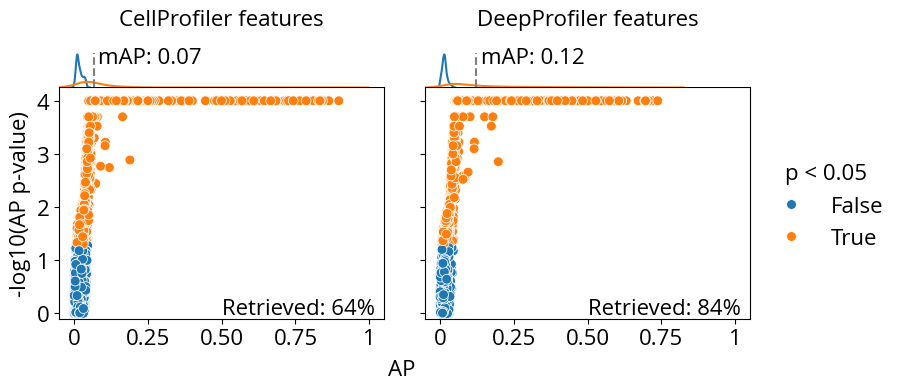

In [6]:
plot_map_x3(gene_ap, "Features", "", row=None, move_legend="lower right",
                aspect=None, adjust=None, s=50, pr_x=0.5, pr_y=0.02, l_x=1.05, l_y=0.575, m_x=0.52, m_y=0.01)

In [7]:
morphoclass_ap = pd.read_csv('../data/processed/Mitocheck_Phenotypic_Class_ap_results.csv')
morphoclass_ap.rename(columns={"average_precision": "AP"}, inplace=True)
morphoclass_ap["Features"] = morphoclass_ap["Features"].replace({"cp": "CellProfiler features", "dp": "DeepProfiler features"})

/tmp/ipykernel_4428/4114252858.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


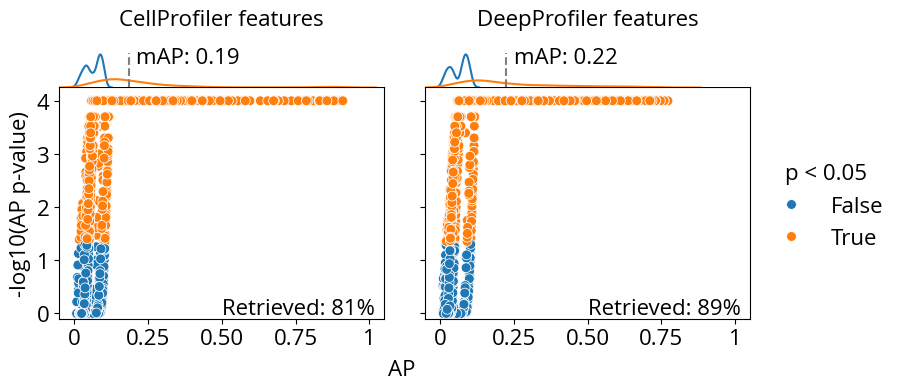

In [8]:
plot_map_x3(morphoclass_ap, "Features", "", row=None, move_legend="lower right",
                aspect=None, adjust=None, s=50, pr_x=0.5, pr_y=0.02, l_x=1.05, l_y=0.575, m_x=0.52, m_y=0.01)

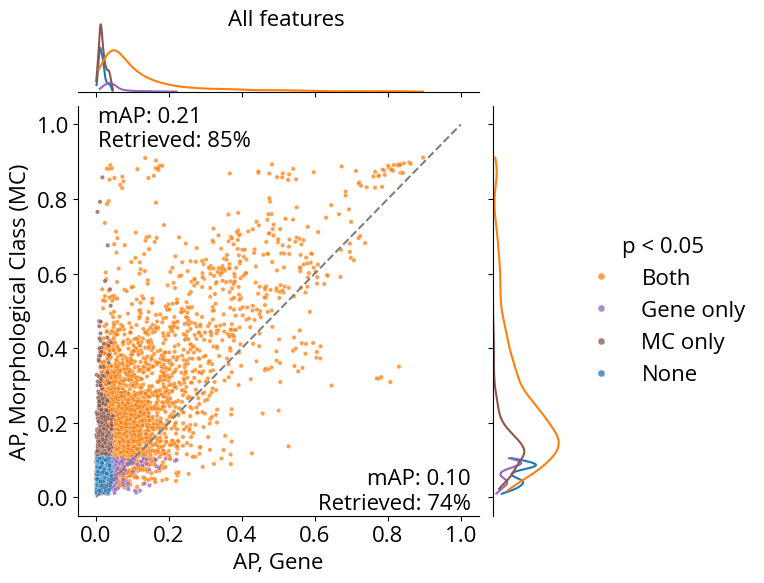

In [9]:
aps = pd.DataFrame([
    gene_ap["AP"],
    gene_ap["p < 0.05"],
    morphoclass_ap["AP"],
    morphoclass_ap["p < 0.05"]
], index=["AP, Gene", "Gene p < 0.05", "AP, Morphological Class (MC)", "MC p < 0.05"]).T

plot_gene_vs_ms(aps, title="All features")

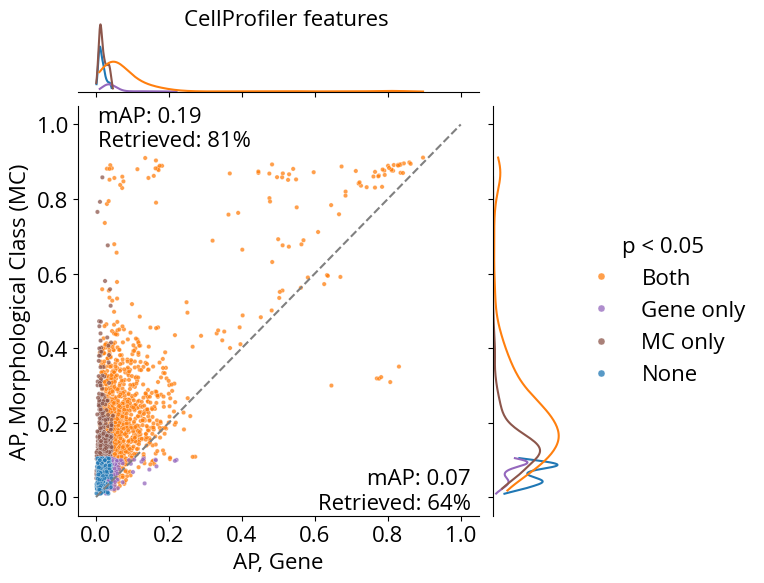

In [10]:
aps = pd.DataFrame([
    gene_ap.query("Features == 'CellProfiler features'")["AP"],
    gene_ap.query("Features == 'CellProfiler features'")["p < 0.05"],
    morphoclass_ap.query("Features == 'CellProfiler features'")["AP"],
    morphoclass_ap.query("Features == 'CellProfiler features'")["p < 0.05"]
], index=["AP, Gene", "Gene p < 0.05", "AP, Morphological Class (MC)", "MC p < 0.05"]).T

plot_gene_vs_ms(aps, title="CellProfiler features")

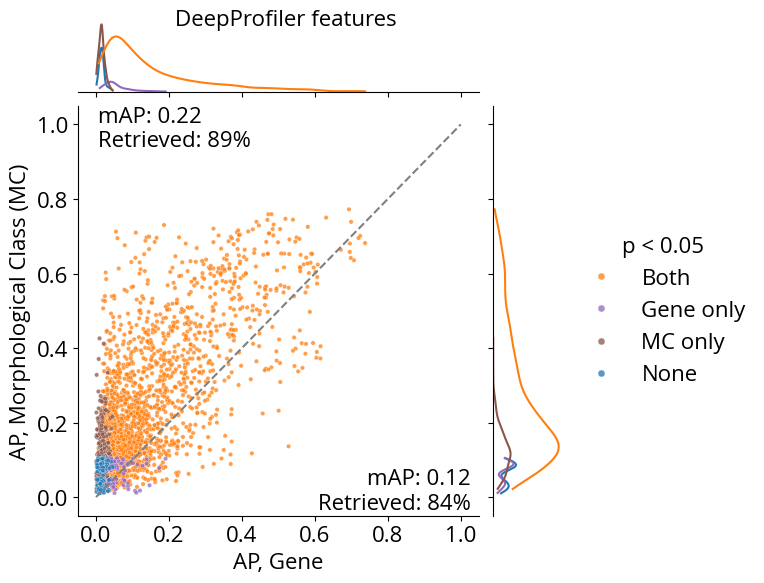

In [11]:
aps = pd.DataFrame([
    gene_ap.query("Features == 'DeepProfiler features'")["AP"],
    gene_ap.query("Features == 'DeepProfiler features'")["p < 0.05"],
    morphoclass_ap.query("Features == 'DeepProfiler features'")["AP"],
    morphoclass_ap.query("Features == 'DeepProfiler features'")["p < 0.05"]
], index=["AP, Gene", "Gene p < 0.05", "AP, Morphological Class (MC)", "MC p < 0.05"]).T

plot_gene_vs_ms(aps, title="DeepProfiler features")

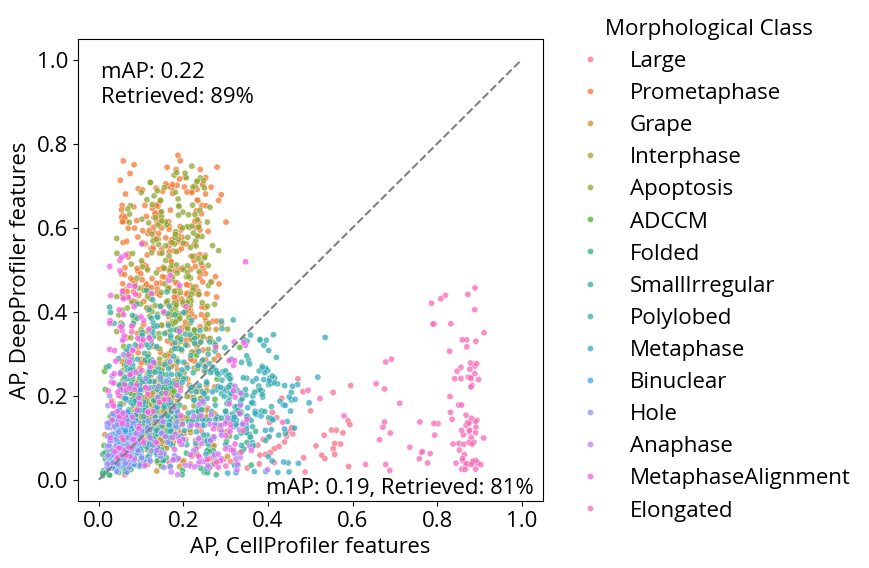

In [12]:
aps = pd.DataFrame([
    morphoclass_ap.query("Features == 'CellProfiler features'")["Mitocheck_Phenotypic_Class"].reset_index(drop=True),
    morphoclass_ap.query("Features == 'CellProfiler features'")["AP"].reset_index(drop=True),
    morphoclass_ap.query("Features == 'CellProfiler features'")["p < 0.05"].reset_index(drop=True),
    morphoclass_ap.query("Features == 'DeepProfiler features'")["AP"].reset_index(drop=True),
    morphoclass_ap.query("Features == 'DeepProfiler features'")["p < 0.05"].reset_index(drop=True),
], index=["Morphological Class", "AP, CellProfiler features", "CellProfiler retrieved", "AP, DeepProfiler features", "DeepProfiler retrieved"]).T

plot_mc_cp_vs_dp(aps, hue="Morphological Class")

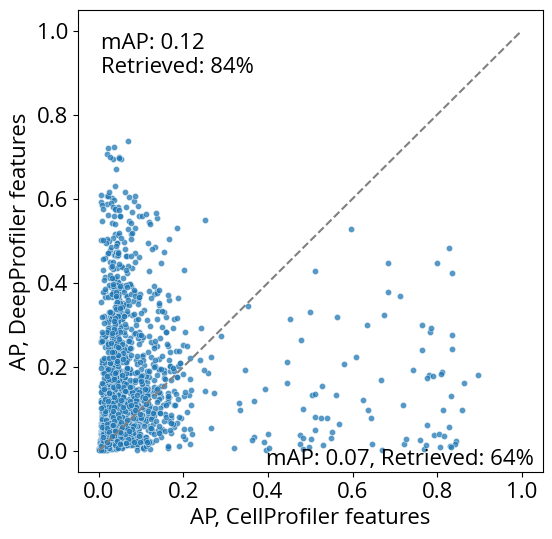

In [13]:
aps = pd.DataFrame([
    gene_ap.query("Features == 'CellProfiler features'")["Metadata_Gene"].reset_index(drop=True),
    gene_ap.query("Features == 'CellProfiler features'")["AP"].reset_index(drop=True),
    gene_ap.query("Features == 'CellProfiler features'")["p < 0.05"].reset_index(drop=True),
    gene_ap.query("Features == 'DeepProfiler features'")["AP"].reset_index(drop=True),
    gene_ap.query("Features == 'DeepProfiler features'")["p < 0.05"].reset_index(drop=True),
], index=["Gene", "AP, CellProfiler features", "CellProfiler retrieved", "AP, DeepProfiler features", "DeepProfiler retrieved"]).T

plot_mc_cp_vs_dp(aps, hue=None, legend=False)

In [14]:
~morphoclass_ap["p < 0.05"]

0       False
1       False
2       False
3       False
4       False
        ...  
4907    False
4908    False
4909    False
4910    False
4911    False
Name: p < 0.05, Length: 4912, dtype: bool

/tmp/ipykernel_4428/3022081442.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)


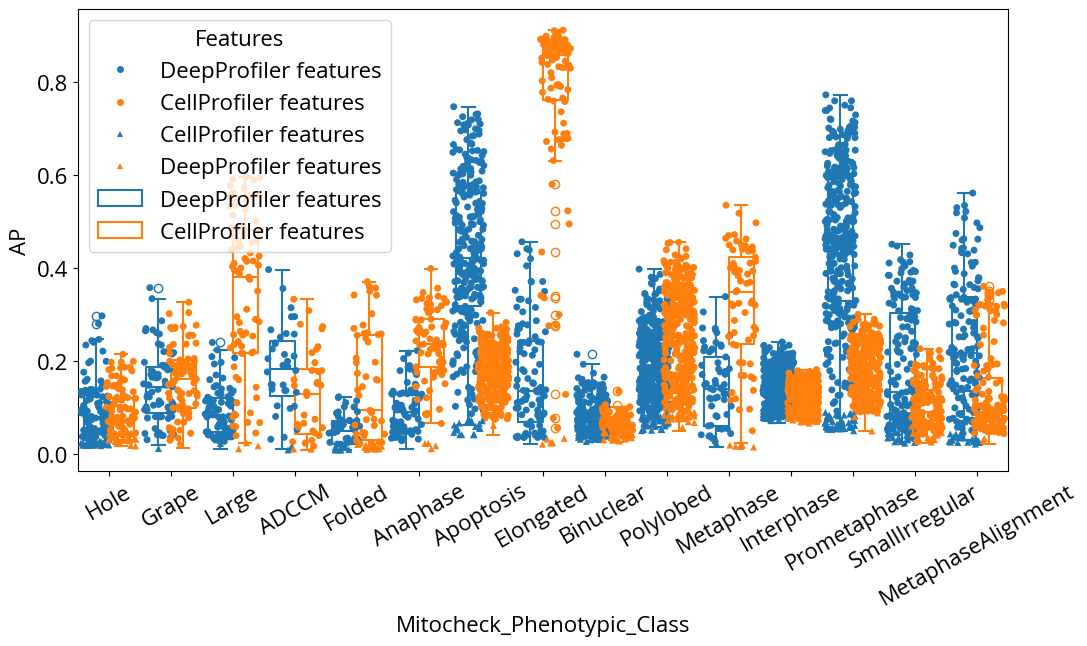

In [15]:
s = morphoclass_ap.Mitocheck_Phenotypic_Class.str.len().sort_values(ascending=True).index
sorted_morphoclass_ap = morphoclass_ap.reindex(s).reset_index(drop=True)

fig = plt.figure(figsize=(12, 6))

ax1 = sns.stripplot(
    data=sorted_morphoclass_ap[sorted_morphoclass_ap["p < 0.05"]],
    x="Mitocheck_Phenotypic_Class",
    y="AP",
    hue="Features",
    dodge=True,
    jitter=0.5
    # kind="swarm",
    # split=True,
    # fill=False,
    # inner="quart"
    # orient='h'
)
ax2 = sns.stripplot(
    data=sorted_morphoclass_ap[~sorted_morphoclass_ap["p < 0.05"]],
    x="Mitocheck_Phenotypic_Class",
    y="AP",
    hue="Features",
    dodge=True,
    jitter=0.5,
    marker="^",
    # kind="swarm",
    # split=True,
    # fill=False,
    # inner="quart"
    # orient='h'
)

ax = sns.boxplot(
    data=sorted_morphoclass_ap,
    x="Mitocheck_Phenotypic_Class",
    y="AP",
    hue="Features",
    fill=False,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

plt.show()

In [16]:
s = (morphoclass_ap[(morphoclass_ap["Features"] == 'CellProfiler features') & morphoclass_ap["p < 0.05"]].groupby('Mitocheck_Phenotypic_Class')['AP'].mean() -
morphoclass_ap[(morphoclass_ap["Features"] == 'DeepProfiler features') & morphoclass_ap["p < 0.05"]].groupby('Mitocheck_Phenotypic_Class')['AP'].mean()).sort_values(ascending=False).index

df = morphoclass_ap.copy()
df['Mitocheck_Phenotypic_Class'] = pd.Categorical(df['Mitocheck_Phenotypic_Class'], categories=s, ordered=True)
df = df.sort_values('Mitocheck_Phenotypic_Class')

/tmp/ipykernel_4428/4005500184.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


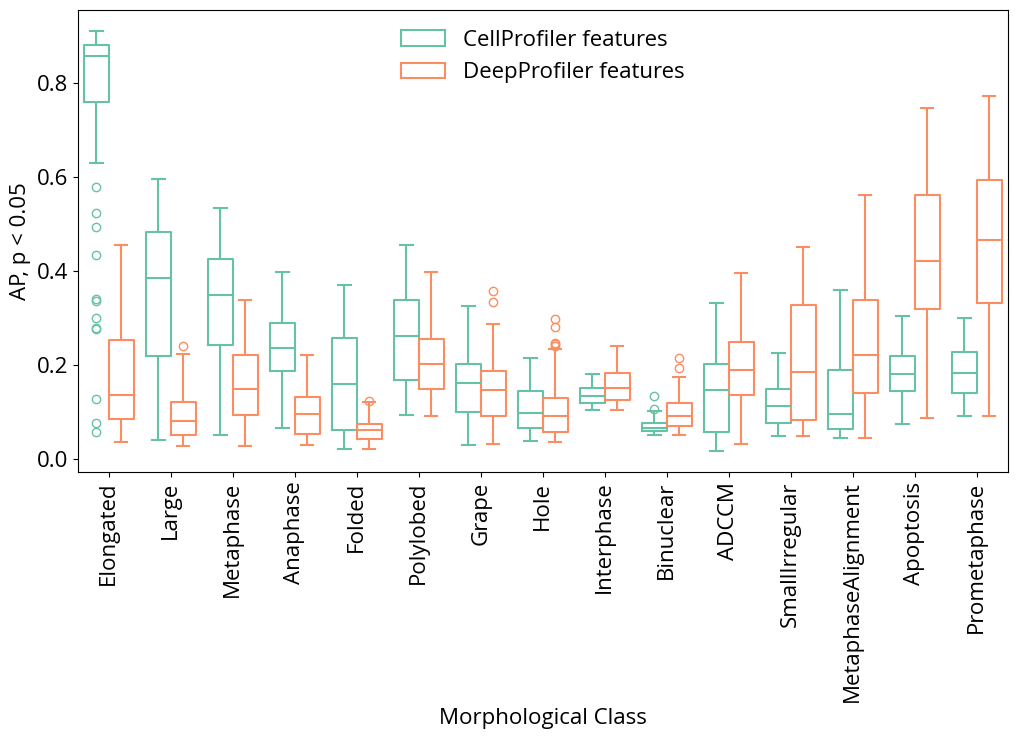

In [19]:
fig = plt.figure(figsize=(12, 6))

ax = sns.boxplot(
    data=df[df["p < 0.05"]].rename(columns={"AP": "AP, p < 0.05", "Mitocheck_Phenotypic_Class": "Morphological Class"}),
    x="Morphological Class",
    y="AP, p < 0.05",
    hue="Features",
    fill=False,
    palette="Set2"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


plt.legend(frameon=False, title=None, loc="upper center")
plt.show()

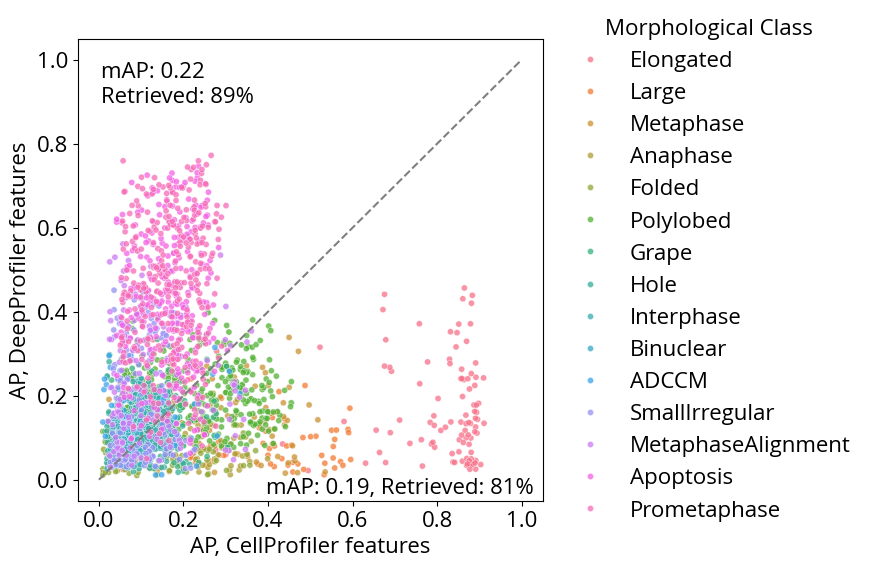

In [18]:
aps = pd.DataFrame([
    df.query("Features == 'CellProfiler features'")["Mitocheck_Phenotypic_Class"].reset_index(drop=True),
    df.query("Features == 'CellProfiler features'")["AP"].reset_index(drop=True),
    df.query("Features == 'CellProfiler features'")["p < 0.05"].reset_index(drop=True),
    df.query("Features == 'DeepProfiler features'")["AP"].reset_index(drop=True),
    df.query("Features == 'DeepProfiler features'")["p < 0.05"].reset_index(drop=True),
], index=["Morphological Class", "AP, CellProfiler features", "CellProfiler retrieved", "AP, DeepProfiler features", "DeepProfiler retrieved"]).T

plot_mc_cp_vs_dp(aps, hue="Morphological Class")

In [21]:
s = (gene_ap[(gene_ap["Features"] == 'CellProfiler features') & gene_ap["p < 0.05"]].groupby('Metadata_Gene')['AP'].mean() -
gene_ap[(gene_ap["Features"] == 'DeepProfiler features') & gene_ap["p < 0.05"]].groupby('Metadata_Gene')['AP'].mean()).sort_values(ascending=False).index

df = gene_ap.copy()
df['Metadata_Gene'] = pd.Categorical(df['Metadata_Gene'], categories=s, ordered=True)
df = df.sort_values('Metadata_Gene')

/tmp/ipykernel_4428/2216121241.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


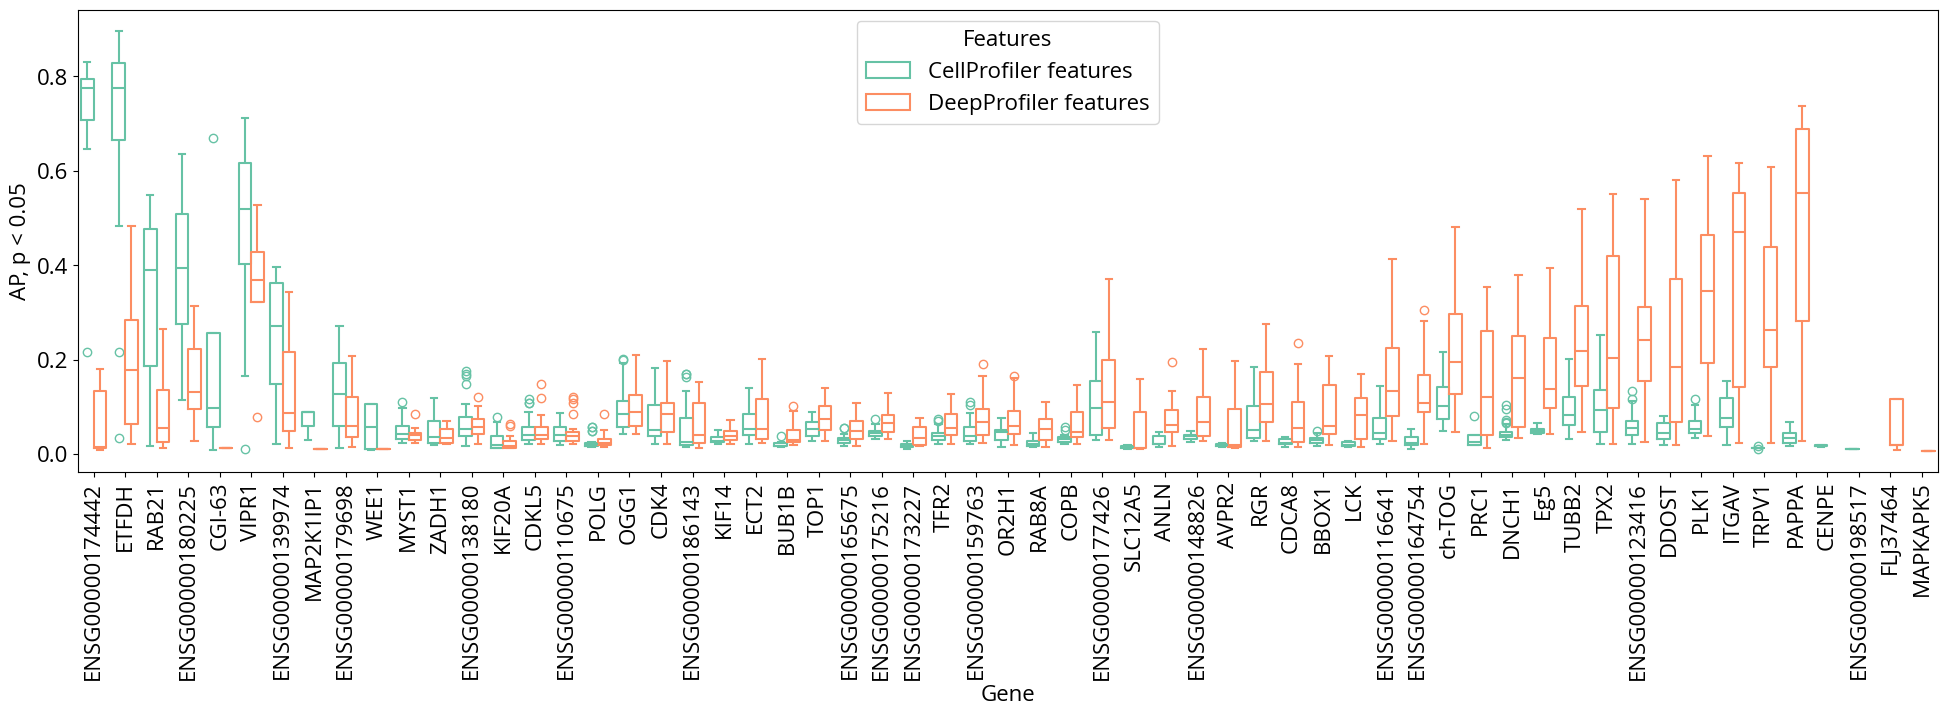

In [22]:
fig = plt.figure(figsize=(24, 6))

ax = sns.boxplot(
    data=df[df["p < 0.05"]].rename(columns={"AP": "AP, p < 0.05", "Metadata_Gene": "Gene"}),
    x="Gene",
    y="AP, p < 0.05",
    hue="Features",
    fill=False,
    palette="Set2"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


# plt.legend(frameon=False, title=None, loc="upper center")
plt.show()

In [24]:
p = (gene_ap[(gene_ap["Features"] == 'CellProfiler features') & gene_ap["p < 0.05"]].groupby('Metadata_Gene')['AP'].mean() -
gene_ap[(gene_ap["Features"] == 'DeepProfiler features') & gene_ap["p < 0.05"]].groupby('Metadata_Gene')['AP'].mean())